In [26]:
#default_exp model.rt

In [27]:
#hide
%reload_ext autoreload
%autoreload 2

In [28]:
#export
import torch
import pandas as pd
import numpy as np

from alphadeep.model.featurize import (
    parse_aa_indices, 
    get_batch_mod_feature
)

from alphadeep.settings import model_const

import alphadeep.model.base as model_base

mod_feature_size = len(model_const['mod_elements'])

def regional_sampling(psm_df:pd.DataFrame, 
    target:str='rt_norm', n_train:int=1000, 
    return_test_df:bool=False,
    random_state=1337,
)->pd.DataFrame:
    """ Divide `psm_df` into 10 bins by values in the `target` 
    column (`rt_norm` or `ccs`), and sample training PSMs (rows) 
    from each bins for model fine-tuning.

    Args:
        psm_df (pd.DataFrame): Dataframe of PSMs.
        target (str, optional): Target columns to sample. 
            Defaults to 'rt_norm'.
        n_train (int, optional): The number of training PSMs 
            to sample. Defaults to 1000.
        return_test_df (bool, optional): If also return `test_df`. 
            `test_df` contains the PSMs that are not sampled.
            Defaults to False.
        random_state: `random_state` in `df.sample()`.

    Returns:
        pd.DataFrame: The sampled training PSMs (dataframe)
        [pd.DataFrame]: The not sampled PSMs (dataframe) for testing. 
            Returned only if `return_test_df==True` in the arguments.
    """
    x = np.arange(0, 11)/10*psm_df[target].max()
    sub_n = n_train//(len(x)-1)
    df_list = []
    for i in range(len(x)-1):
        _df = psm_df[
            (psm_df[target]>=x[i])&(psm_df[target]<x[i+1])
        ]
        if len(_df) == 0: pass
        elif len(_df)//2 < sub_n:
            df_list.append(_df.sample(
                len(_df)//2, 
                replace=False,
                random_state=random_state
            ))
        else:
            df_list.append(_df.sample(
                sub_n, 
                replace=False,
                random_state=random_state
            ))
    if return_test_df:
        if len(df_list) == 0:
            return pd.DataFrame(), pd.DataFrame()
        train_df = pd.concat(df_list)
        test_df = psm_df.drop(train_df.index)
        return train_df, test_df
    else:
        if len(df_list) == 0:
            return pd.DataFrame()
        return pd.concat(df_list)

# wrapper for legacy
uniform_sampling = regional_sampling


In [29]:
#export
class ModelRTTransformer(torch.nn.Module):
    def __init__(self,
        dropout = 0.1,
        nlayers = 4,
        hidden = 128,
        **kwargs,
    ):
        super().__init__()

        self.dropout = torch.nn.Dropout(dropout)

        self.input_nn = model_base.AATransformerEncoding(hidden)

        self.hidden_nn = model_base.HiddenTransformer(
            hidden, nlayers=nlayers, dropout=dropout
        )

        self.output_nn = torch.nn.Sequential(
            model_base.SeqAttentionSum(hidden),
            torch.nn.PReLU(),
            self.dropout,
            torch.nn.Linear(hidden, 1),
        )

    def forward(self, 
        aa_indices, 
        mod_x,
    ):
        x = self.dropout(self.input_nn(
            aa_indices, mod_x
        ))

        x = self.hidden_nn(x)

        return self.output_nn(x).squeeze(1)


In [30]:
#export
class ModelRTLSTM(torch.nn.Module):
    def __init__(self, 
        dropout=0.2,
        **kwargs,
    ):
        super().__init__()
        
        self.dropout = torch.nn.Dropout(dropout)
        
        hidden = 256
        self.rt_encoder = model_base.Input_AA_CNN_LSTM_Encoder(
            hidden
        )

        self.rt_decoder = model_base.LinearDecoder(
            hidden,
            1
        )

    def forward(self, 
        aa_indices, 
        mod_x,
    ):
        x = self.rt_encoder(aa_indices, mod_x)
        x = self.dropout(x)

        return self.rt_decoder(x).squeeze(1)

In [31]:
#export
class AlphaRTModel(model_base.ModelImplBase):
    def __init__(self, 
        dropout=0.1, lr=0.001,
        model_class:torch.nn.Module=ModelRTLSTM,
        **kwargs,
    ):
        super().__init__()
        self.build(
            model_class,
            dropout=dropout,
            **kwargs
        )
        self.loss_func = torch.nn.L1Loss()

    def _prepare_predict_data_df(self,
        precursor_df:pd.DataFrame,
    ):
        precursor_df['rt_pred'] = 0.
        self.predict_df = precursor_df

    def _get_features_from_batch_df(self, 
        batch_df: pd.DataFrame, 
        nAA
    ):
        aa_indices = torch.LongTensor(
            parse_aa_indices(
                batch_df['sequence'].values.astype('U')
            )
        )

        mod_x_batch = get_batch_mod_feature(batch_df, nAA)
        mod_x = torch.Tensor(mod_x_batch)

        return aa_indices, mod_x

    def _get_targets_from_batch_df(self, 
        batch_df: pd.DataFrame, 
        **kwargs,
    ) -> torch.Tensor:
        return torch.Tensor(batch_df['rt_norm'].values)

    def _set_batch_predict_data(self, 
        batch_df: pd.DataFrame, 
        predicts: np.array,
    ):
        predicts[predicts<0] = 0.0
        if self._predict_in_order:
            self.predict_df.loc[:,'rt_pred'].values[
                batch_df.index.values[0]:batch_df.index.values[-1]+1
            ] = predicts
        else:
            self.predict_df.loc[
                batch_df.index,'rt_pred'
            ] = predicts

    def rt_to_irt_pred(self,
        precursor_df: pd.DataFrame
    ):
        convert_predicted_rt_to_irt(precursor_df, self)

In [32]:
model = AlphaRTModel()
model.device = torch.device('cpu')
model.model.to(model.device)
mod_hidden = len(model_const['mod_elements'])
model.model(torch.LongTensor([[1,2,3,4,5,6]]), torch.tensor([[[0.0]*mod_hidden]*6]))

tensor([-0.1545], grad_fn=<SqueezeBackward1>)

In [33]:
model.get_parameter_num()

796792

In [34]:
model.model

ModelRTTransformer(
  (dropout): Dropout(p=0.1, inplace=False)
  (input_nn): AATransformerEncoding(
    (mod_nn): InputModNetFixFirstK(
      (nn): Linear(in_features=103, out_features=2, bias=False)
    )
    (aa_emb): Embedding(27, 120, padding_idx=0)
    (pos_encoder): PositionalEncoding()
  )
  (hidden_nn): HiddenTransformer(
    (transormer): SeqTransformer(
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
            )
            (linear1): Linear(in_features=128, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=128, bias=True)
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (

In [35]:
repeat = 10
precursor_df = pd.DataFrame({
    'sequence': ['AGHCEWQMKYR']*repeat,
    'mods': ['Acetyl@Protein N-term;Carbamidomethyl@C;Oxidation@M']*repeat,
    'mod_sites': ['0;4;8']*repeat,
    'nAA': [11]*repeat,
    'rt_norm': [0.6]*repeat
})
precursor_df

,sequence,mods,mod_sites,nAA,rt_norm
0,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
1,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
2,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
3,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
4,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
5,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
6,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
7,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
8,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
9,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6


In [36]:

model.train(precursor_df, epoch=5, verbose_each_epoch=True)

Epoch=5, nAA=11, Batch=1, Loss=0.1409: 100%|██████████| 1/1 [00:00<00:00, 24.36it/s]


In [37]:
model.predict(precursor_df)

,sequence,mods,mod_sites,nAA,rt_norm,rt_pred
0,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.375405
1,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.375405
2,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.375405
3,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.375405
4,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.375405
5,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.375405
6,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.375405
7,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.375405
8,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.375405
9,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.375405


In [38]:
#export
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_linear_regression(
    df:pd.DataFrame, x='rt_pred', y='rt_norm', 
    ci=95, n_sample=100000
):
    if len(df) > n_sample:
        df = df.sample(n_sample, replace=False)
    gls = sm.GLS(df[y], sm.add_constant(df[x]))
    res = gls.fit()
    summary = res.summary(alpha=1-ci/100.0)
    dfs = []
    results_as_html = summary.tables[0].as_html()
    dfs.append(pd.read_html(results_as_html, index_col=None)[0])
    results_as_html = summary.tables[1].as_html()
    dfs.append(pd.read_html(results_as_html, index_col=None)[0])
    summary = pd.concat(dfs).reset_index(drop=True)
    R_square = float(summary.loc[0,3])
    R = np.sqrt(R_square)
    n,b,w = summary.loc[[5,10,11],1].values.astype(float)
    return pd.DataFrame(
        dict(
            R_square=[R_square],R=[R],
            slope=[w],intercept=[b],n_sample=[n]
        )
    )

def evaluate_linear_regression_plot(
    df:pd.DataFrame, x='rt_pred', y='rt_norm', 
    ci=95, n_sample=100000
):
    if len(df) > n_sample:
        df = df.sample(n_sample)
    alpha = 0.05
    if len(df) < 5000:
        alpha = 1
    elif len(df) < 50000:
        alpha = 5000.0/len(df)
    sns.regplot(
        data=df, x=x, y=y, color='r', ci=ci, 
        scatter_kws={'s':0.05, 'alpha':alpha, 'color':'b'}
    )
    plt.show()

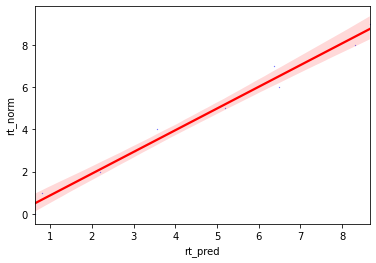

In [39]:
#hide
import pandas as pd
import numpy as np
df = pd.DataFrame({'rt_norm':np.arange(10), 'rt_pred':np.arange(10)+np.random.normal(0,0.3,10)})
evaluate_linear_regression_plot(df)

In [40]:
#export
irt_pep = pd.DataFrame(
    [['LGGNEQVTR', 'RT-pep a', -24.92, '', ''],
    ['GAGSSEPVTGLDAK', 'RT-pep b', 0.00, '', ''],
    ['VEATFGVDESNAK', 'RT-pep c', 12.39, '', ''],
    ['YILAGVENSK', 'RT-pep d', 19.79, '', ''],
    ['TPVISGGPYEYR', 'RT-pep e', 28.71, '', ''],
    ['TPVITGAPYEYR', 'RT-pep f', 33.38, '', ''],
    ['DGLDAASYYAPVR', 'RT-pep g', 42.26, '', ''],
    ['ADVTPADFSEWSK', 'RT-pep h', 54.62, '', ''],
    ['GTFIIDPGGVIR', 'RT-pep i', 70.52, '', ''],
    ['GTFIIDPAAVIR', 'RT-pep k', 87.23, '', ''],
    ['LFLQFGAQGSPFLK', 'RT-pep l', 100.00, '', '']],
    columns=['sequence','pep_name','irt', 'mods', 'mod_sites']
)
irt_pep['nAA'] = irt_pep.sequence.str.len()

def convert_predicted_rt_to_irt(
    df:pd.DataFrame, rt_model:AlphaRTModel
)->pd.DataFrame:
    rt_model.predict(irt_pep)
    # simple linear regression
    rt_pred_mean = irt_pep.rt_pred.mean()
    irt_mean = irt_pep.irt.mean()
    x = irt_pep.rt_pred.values - rt_pred_mean
    y = irt_pep.irt.values - irt_mean
    slope = np.sum(x*y)/np.sum(x*x)
    intercept = irt_mean - slope*rt_pred_mean
    # end linear regression
    df['irt_pred'] = df.rt_pred*slope + intercept
    return df

In [41]:
#hide
irt_pep

,sequence,pep_name,irt,mods,mod_sites,nAA
0,LGGNEQVTR,RT-pep a,-24.92,,,9
1,GAGSSEPVTGLDAK,RT-pep b,0.00,,,14
2,VEATFGVDESNAK,RT-pep c,12.39,,,13
3,YILAGVENSK,RT-pep d,19.79,,,10
4,TPVISGGPYEYR,RT-pep e,28.71,,,12
5,TPVITGAPYEYR,RT-pep f,33.38,,,12
6,DGLDAASYYAPVR,RT-pep g,42.26,,,13
7,ADVTPADFSEWSK,RT-pep h,54.62,,,13
8,GTFIIDPGGVIR,RT-pep i,70.52,,,12
9,GTFIIDPAAVIR,RT-pep k,87.23,,,12


In [42]:
#hide
from alphadeep.pretrained_models import ModelManager
models = ModelManager()
models.load_installed_models()
irt_pep = models.rt_model.predict(irt_pep)
irt_pep = convert_predicted_rt_to_irt(irt_pep, models.rt_model)
irt_pep

,sequence,pep_name,irt,mods,mod_sites,nAA,rt_pred,irt_pred
0,LGGNEQVTR,RT-pep a,-24.92,,,9,0.072804,-28.148849
1,GAGSSEPVTGLDAK,RT-pep b,0.00,,,14,0.271196,2.053492
2,VEATFGVDESNAK,RT-pep c,12.39,,,13,0.332649,11.408902
3,YILAGVENSK,RT-pep d,19.79,,,10,0.400949,21.806524
4,TPVISGGPYEYR,RT-pep e,28.71,,,12,0.438901,27.584271
5,TPVITGAPYEYR,RT-pep f,33.38,,,12,0.489774,35.328937
6,DGLDAASYYAPVR,RT-pep g,42.26,,,13,0.542729,43.390475
7,ADVTPADFSEWSK,RT-pep h,54.62,,,13,0.609782,53.598396
8,GTFIIDPGGVIR,RT-pep i,70.52,,,12,0.757164,76.035216
9,GTFIIDPAAVIR,RT-pep k,87.23,,,12,0.846791,89.679588


In [43]:
assert irt_pep.rt_pred.is_monotonic